In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv("../data/USD rates.csv")
data.head()

,USD Rate MKT Data,Unnamed: 1,"Conv, adj",StartDate,EndDate
0,Libor3m,0.001295,NaN,10/28/21,1/28/22
1,EDZ1,99.810000,0.00014,12/15/21,3/15/22
2,EDH2,99.785000,0.00073,3/16/22,6/16/22
3,EDM2,99.680000,0.00165,6/15/22,9/15/22
4,EDU2,99.520000,0.00287,9/21/22,12/21/22


Преобразуем дату в доли года.

In [3]:
data.StartDate = pd.to_datetime(data.StartDate)
data.EndDate = pd.to_datetime(data.EndDate)
min_year = data.StartDate.dt.year.min()

In [4]:
data["StartDateShare"] = (data.StartDate.dt.month * 12 + data.StartDate.dt.day) / 360 +(data.StartDate.dt.year - min_year)

In [5]:
data["EndDateShare"] = (data.EndDate.dt.month * 12 + data.EndDate.dt.day) / 360 + (data.EndDate.dt.year - min_year)

Преобразуем цены фьючерсов в форвардные ставки. Также будем учитывать то, что фьючерсные ставки выше так, как несут в себе дополнительный риск (margin call).

In [6]:
data["rates"] = data["Unnamed: 1"]
data.loc[1:, "rates"] = 1 - 0.01*data.loc[1:, "rates"] - data.loc[1:, "Conv, adj"]

In [7]:
data.head()

,USD Rate MKT Data,Unnamed: 1,"Conv, adj",StartDate,EndDate,StartDateShare,EndDateShare,rates
0,Libor3m,0.001295,NaN,2021-10-28,2022-01-28,0.411111,1.111111,0.001295
1,EDZ1,99.810000,0.00014,2021-12-15,2022-03-15,0.441667,1.141667,0.001760
2,EDH2,99.785000,0.00073,2022-03-16,2022-06-16,1.144444,1.244444,0.001420
3,EDM2,99.680000,0.00165,2022-06-15,2022-09-15,1.241667,1.341667,0.001550
4,EDU2,99.520000,0.00287,2022-09-21,2022-12-21,1.358333,1.458333,0.001930


Получим массивы, которые будут поданы на вход интерполятору.

In [8]:
index = np.array(list(data["StartDateShare"]) + list(data["EndDateShare"]))
rates = np.array(list(data["rates"]) * 2)

In [9]:
index_sort = index.argsort()
rates = rates[index_sort]
index.sort()

In [10]:
index

array([0.41111111, 0.44166667, 1.11111111, 1.14166667, 1.14444444,
       1.24166667, 1.24444444, 1.34166667, 1.35833333, 1.45833333,
       1.45833333, 2.14166667, 2.15833333, 2.24166667, 2.25833333,
       2.35555556, 2.35833333, 2.45555556, 2.45555556, 3.15555556,
       3.15555556, 3.25277778, 3.25555556, 3.35      , 3.35277778,
       3.45      ])

In [11]:
class LinearInterpolation:
    """
        Class for linear interolation. Work only for scalar function.
    """
    def __init__(self, x, y):
        """
            Params:
                x: array of function arguments
                y: array of responses
        """
        self.x = x
        self.y = y
    
    def interpolate(self, z):
        """
            Params:
                z: scalar argument
            Return:
                y: response
        """
        ind = ((self.x - z) > 0).argmax()
        y = self.y[ind-1] + (self.y[ind] - self.y[ind-1]) / (self.x[ind] - self.x[ind-1]) * (z - self.x[ind-1])
        return y

In [12]:
import numpy as np
z = np.linspace(index.min(), index.max(), 1000)
interpolate_rates = []
for i in z:
    interpolate_rates.append(LinearInterpolation(index, rates).interpolate(i))
interpolate_rates = np.array(interpolate_rates)

Визуализируем интерполяцию между ставками.

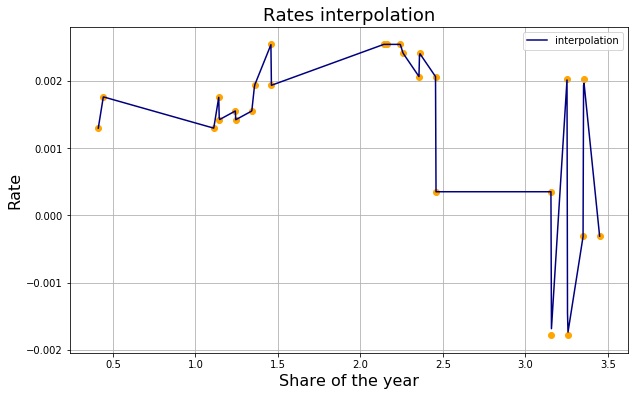

In [16]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
plt.title("Rates interpolation", fontsize=18)
plt.xlabel("Share of the year", fontsize=16)
plt.ylabel("Rate", fontsize=16)
plt.plot(z, interpolate_rates, c="navy", label="interpolation")
plt.scatter(index, rates, c="orange")
plt.legend()
plt.grid()
plt.show()

Получим и визуализируем кривую доходностей.

In [14]:
yield_curve = 100 / (1+interpolate_rates)

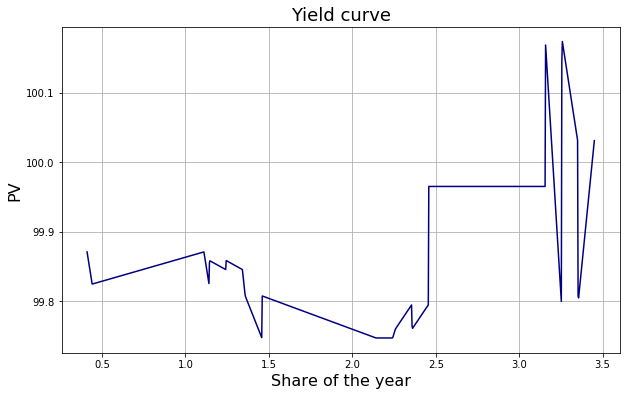

In [15]:
fig = plt.figure(figsize=(10, 6))
plt.title("Yield curve", fontsize=18)
plt.xlabel("Share of the year", fontsize=16)
plt.ylabel("PV", fontsize=16)
plt.plot(z, yield_curve, c="navy")
#plt.legend()
plt.grid()
plt.show()

Кривая выглядит достаточно странно, слишком много флуктуаций. Может быть я сделал что-то не то.